<a href="https://colab.research.google.com/github/arunangshu19/PINN/blob/main/Allen_Cahn_2%2B1_doublestage_ic_overlap_no_annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda:0
--- Starting Stage 1: Pre-training on Initial Condition for 20000 iterations ---
Pre-train Iteration 0, IC Loss: 0.513202
Pre-train Iteration 1000, IC Loss: 0.420930
Pre-train Iteration 2000, IC Loss: 0.197161
Pre-train Iteration 3000, IC Loss: 0.030620
Pre-train Iteration 4000, IC Loss: 0.008638
Pre-train Iteration 5000, IC Loss: 0.004105
Pre-train Iteration 6000, IC Loss: 0.002460
Pre-train Iteration 7000, IC Loss: 0.001926
Pre-train Iteration 8000, IC Loss: 0.000955
Pre-train Iteration 9000, IC Loss: 0.000743
Pre-train Iteration 10000, IC Loss: 0.000316
Pre-train Iteration 11000, IC Loss: 0.000372
Pre-train Iteration 12000, IC Loss: 0.000415
Pre-train Iteration 13000, IC Loss: 0.000577
Pre-train Iteration 14000, IC Loss: 0.000350
Pre-train Iteration 15000, IC Loss: 0.000301
Pre-train Iteration 16000, IC Loss: 0.000177
Pre-train Iteration 17000, IC Loss: 0.000111
Pre-train Iteration 18000, IC Loss: 0.000076
Pre-train Iteration 19000, IC Loss: 0.000072
Pre-trainin

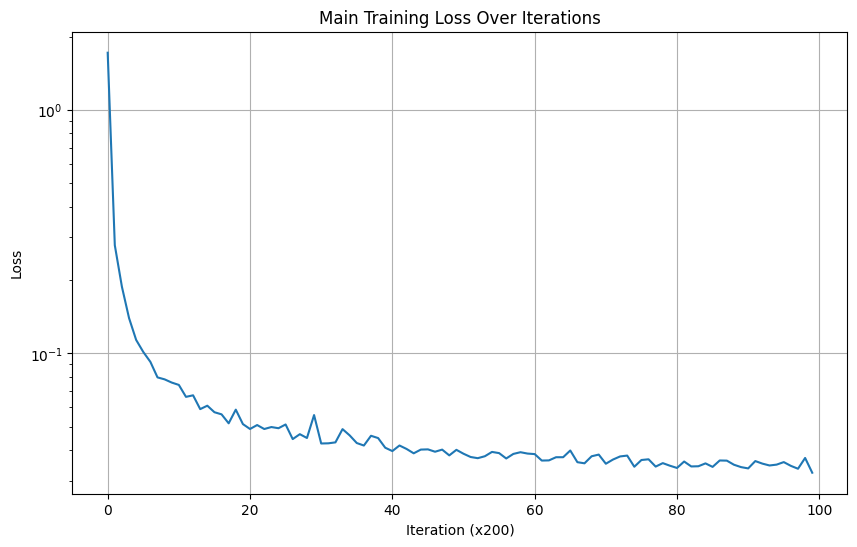


Plotting Final vs. Ground Truth...


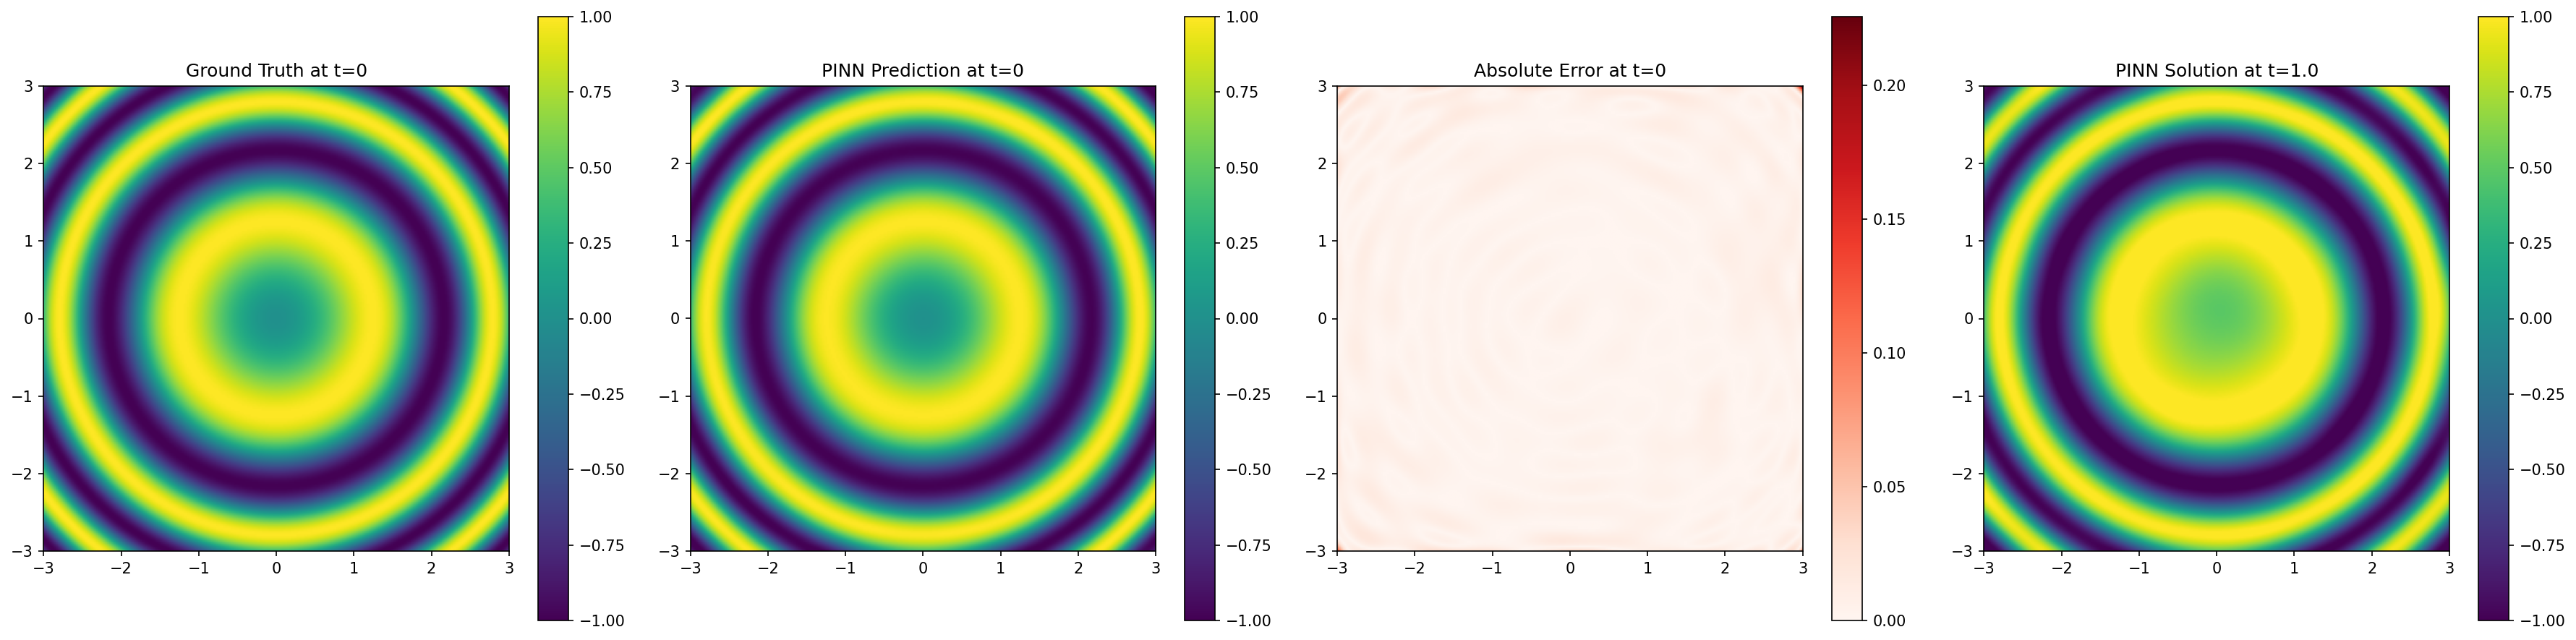


Plotting the solution at intermediate time steps...


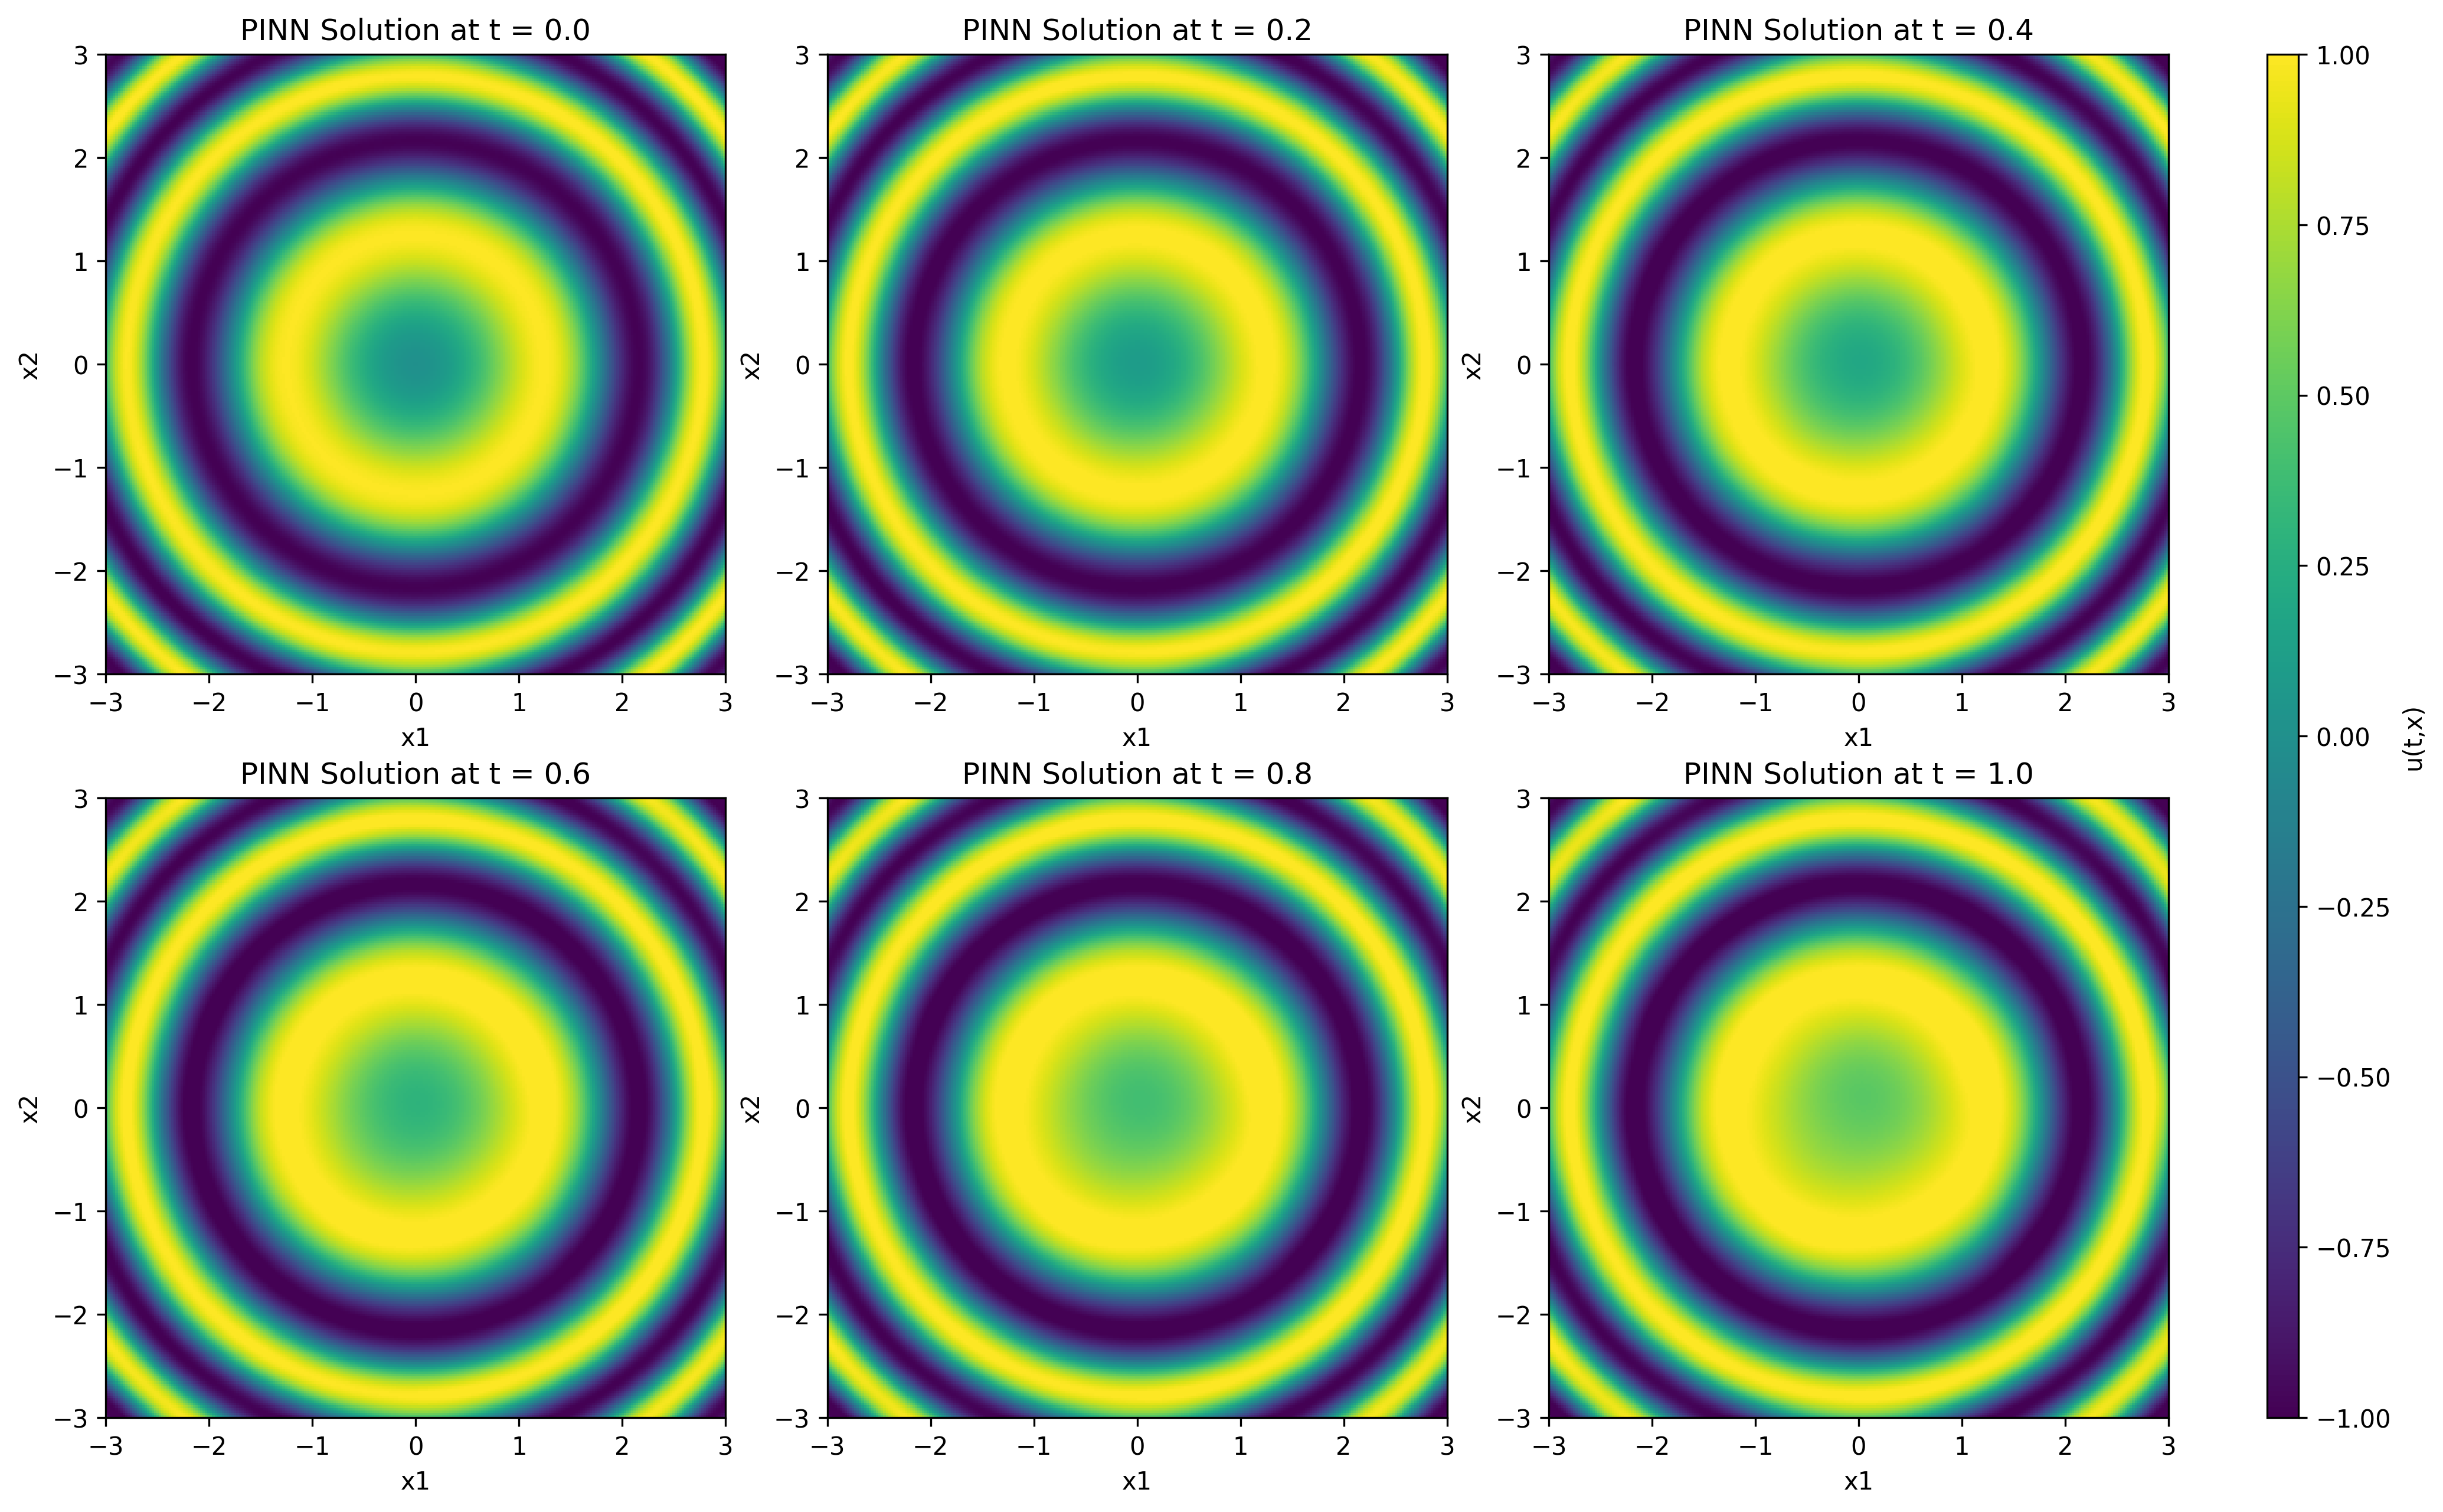

In [3]:
# --- Imports ---
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import grad
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import time
import random

# --- Reproducibility ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# --- Device Setup ---
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {dev}")

# --- Custom Sine Activation Module ---
class Sine(torch.nn.Module):
    def forward(self, x):
        return torch.sin(x)

# --- Parameters ---
T = 1.0
M_pde = 40000
M_initial = 10000

# --- Data Generation ---
x_pde_train = (torch.rand(M_pde, 2, device=dev) * 6) - 3
t_pde_train = torch.rand(M_pde, 1, device=dev) * T
x_initial_train = (torch.rand(M_initial, 2, device=dev) * 6) - 3

# --- Initial Condition Function ---
def phi(x):
    return torch.sin(torch.sum(x**2, axis=1, keepdims=True))

# --- Network Definition ---
hidden_neurons = 256
N = torch.nn.Sequential(
    torch.nn.Linear(3, hidden_neurons), Sine(),
    torch.nn.Linear(hidden_neurons, hidden_neurons), Sine(),
    torch.nn.Linear(hidden_neurons, hidden_neurons), Sine(),
    torch.nn.Linear(hidden_neurons, hidden_neurons), Sine(),
    torch.nn.Linear(hidden_neurons, 1),
).to(dev)

# --- Optimizer and Scheduler ---
optimizer = torch.optim.Adam(N.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

# --- Training Hyperparameters ---
J_pde = 1024
J_initial = 1024
k_pretrain = 20000
k_main = 20000

# --- STAGE 1: PRE-TRAINING ON INITIAL CONDITION ---
print(f"--- Starting Stage 1: Pre-training on Initial Condition for {k_pretrain} iterations ---")
start_time = time.time()
for i in range(k_pretrain):
    optimizer.zero_grad()

    initial_indices = torch.randint(0, M_initial, (J_initial,))
    x_ic = x_initial_train[initial_indices, :]
    t_ic = torch.zeros_like(x_ic[:, :1])

    u0_pred = N(torch.hstack((t_ic, x_ic)))
    loss = (u0_pred - phi(x_ic)).square().mean()

    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        print(f"Pre-train Iteration {i}, IC Loss: {loss.item():.6f}")

print(f"Pre-training finished in {time.time() - start_time:.2f} seconds.")

# --- STAGE 2: MAIN TRAINING WITH PDE LOSS ANNEALING ---
print(f"\n--- Starting Stage 2: Main Training for {k_main} iterations ---")
training_loss_history = []
start_time = time.time()
# pde_weight_anneal_steps = 5000.0

for i in range(k_main):
    optimizer.zero_grad()

    # lambda_pde = min(1.0, i / pde_weight_anneal_steps)

    # Initial Condition Loss
    initial_indices = torch.randint(0, M_initial, (J_initial,))
    x_ic = x_initial_train[initial_indices, :]
    t_ic = torch.zeros_like(x_ic[:, :1])
    u0_pred = N(torch.hstack((t_ic, x_ic)))
    initial_loss = (u0_pred - phi(x_ic)).square().mean()

    # PDE Loss
    pde_indices = torch.randint(0, M_pde, (J_pde,))
    x_c = x_pde_train[pde_indices, :]
    t_c = t_pde_train[pde_indices, :]
    x1_c, x2_c = x_c[:, 0:1], x_c[:, 1:2]
    x1_c.requires_grad_()
    x2_c.requires_grad_()
    t_c.requires_grad_()

    u = N(torch.hstack((t_c, x1_c, x2_c)))
    u_t = grad(u, t_c, torch.ones_like(u), create_graph=True)[0]
    u_x1 = grad(u, x1_c, torch.ones_like(u), create_graph=True)[0]
    u_x2 = grad(u, x2_c, torch.ones_like(u), create_graph=True)[0]
    u_x1x1 = grad(u_x1, x1_c, torch.ones_like(u_x1), create_graph=True)[0]
    u_x2x2 = grad(u_x2, x2_c, torch.ones_like(u_x2), create_graph=True)[0]
    pde_residual = u_t - (0.005 * (u_x1x1 + u_x2x2) + u - u**3)
    pde_loss = pde_residual.square().mean()

    loss = 100 * initial_loss +  pde_loss

    loss.backward()
    optimizer.step()
    scheduler.step()

    if i % 200 == 0:
        training_loss_history.append(loss.item())
        if i % 1000 == 0:
             print(f"Main Iteration {i}, Loss: {loss.item():.10f}")

print(f"Main training finished in {time.time() - start_time:.2f} seconds.")

# --- PLOTTING SECTION ---

# --- Plot 1: Training Loss ---
plt.figure(figsize=(10, 6))
plt.plot(training_loss_history)
plt.xlabel('Iteration (x200)')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Main Training Loss Over Iterations')
plt.grid(True)
plt.show()

# --- Plot 2: Prediction and Ground Truth Comparison at t=0 ---
print("\nPlotting Final vs. Ground Truth...")
N.eval()

fig_compare = plt.figure(figsize=(24, 6), dpi=150)
gs_compare = GridSpec(1, 4)
mesh_plot = 256
a, b = -3, 3

x_plot_grid, y_plot_grid = torch.meshgrid(
    torch.linspace(a, b, mesh_plot, device=dev),
    torch.linspace(a, b, mesh_plot, device=dev),
    indexing="xy"
)
xy_flat = torch.hstack((x_plot_grid.reshape(-1, 1), y_plot_grid.reshape(-1, 1)))
vmin, vmax = -1.0, 1.0

with torch.no_grad():
    ax_true = fig_compare.add_subplot(gs_compare[0, 0])
    z_true = phi(xy_flat).cpu().numpy().reshape((mesh_plot, mesh_plot))
    im1 = ax_true.imshow(z_true, cmap="viridis", extent=[a, b, a, b], vmin=vmin, vmax=vmax)
    ax_true.set_title("Ground Truth at t=0")
    fig_compare.colorbar(im1, ax=ax_true)

    ax_pinn_t0 = fig_compare.add_subplot(gs_compare[0, 1])
    t_zero = torch.zeros_like(xy_flat[:, :1])
    u_pred_t0 = N(torch.cat((t_zero, xy_flat), 1))
    z_pinn_t0 = u_pred_t0.cpu().numpy().reshape((mesh_plot, mesh_plot))
    im2 = ax_pinn_t0.imshow(z_pinn_t0, cmap="viridis", extent=[a, b, a, b], vmin=vmin, vmax=vmax)
    ax_pinn_t0.set_title("PINN Prediction at t=0")
    fig_compare.colorbar(im2, ax=ax_pinn_t0)

    ax_err = fig_compare.add_subplot(gs_compare[0, 2])
    z_error = np.abs(z_true - z_pinn_t0)
    im3 = ax_err.imshow(z_error, cmap="Reds", extent=[a, b, a, b])
    ax_err.set_title("Absolute Error at t=0")
    fig_compare.colorbar(im3, ax=ax_err)

    ax_pinn_t1 = fig_compare.add_subplot(gs_compare[0, 3])
    t_final = torch.ones_like(xy_flat[:, :1]) * T
    u_pred_t1 = N(torch.cat((t_final, xy_flat), 1))
    z_pinn_t1 = u_pred_t1.cpu().numpy().reshape((mesh_plot, mesh_plot))
    im4 = ax_pinn_t1.imshow(z_pinn_t1, cmap="viridis", extent=[a, b, a, b], vmin=vmin, vmax=vmax)
    ax_pinn_t1.set_title("PINN Solution at t=1.0")
    fig_compare.colorbar(im4, ax=ax_pinn_t1)

plt.tight_layout()
plt.show()


# --- Plot 3: Time Evolution of the PINN Solution (6 steps) ---
print("\nPlotting the solution at intermediate time steps...")
fig_evol = plt.figure(figsize=(16, 10), dpi=300)
gs_evol = GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05])

time_steps_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for i, t_val in enumerate(time_steps_to_plot):
  with torch.no_grad():
    t_plot = torch.full((mesh_plot**2, 1), t_val, device=dev)
    z = N(torch.cat((t_plot, xy_flat), 1))
    z = z.cpu().numpy().reshape((mesh_plot, mesh_plot))

  ax = fig_evol.add_subplot(gs_evol[i // 3, i % 3])
  ax.set_title(f"PINN Solution at t = {t_val:.1f}")
  im = ax.imshow(z, cmap="viridis", extent=[a, b, a, b], vmin=vmin, vmax=vmax)
  ax.set_xlabel("x1")
  ax.set_ylabel("x2")

norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap="viridis", norm=norm)
cax = fig_evol.add_subplot(gs_evol[:, 3])
fig_evol.colorbar(sm, cax=cax, orientation='vertical', label='u(t,x)')
plt.show()